<a href="https://colab.research.google.com/github/MercyMoparthy/CNN-Project/blob/main/CSNNModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSNN Model library installation - TORCH

In [2]:
!pip install snntorch torch torchvision numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

## Importing Libraries for CSNN Model

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import snntorch as snn
from snntorch import surrogate
import snntorch.functional as SF
import numpy as np
import matplotlib.pyplot as plt

## Check if CUDA is available

In [4]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Processing

In [5]:
# Data Loading and Preprocessing
tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 41.9MB/s]


## Built the Model

In [11]:
# Define the CSNN Model
class CSNN(nn.Module):
    def __init__(self, num_steps=25, beta=0.95):
        super().__init__()
        self.num_steps = num_steps

        # Spike gradient surrogate
        spike_grad = surrogate.fast_sigmoid()

        # Network architecture
        self.conv1 = nn.Conv2d(3, 12, 5, padding=2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.bn = nn.BatchNorm2d(12)

        self.conv2 = nn.Conv2d(12, 32, 3, padding=1)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.pool = nn.AvgPool2d(2)

        self.fc1 = nn.Linear(64 * 4 * 4, 10)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, output=True)

    def forward(self, x):
        # Initialize hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_out_rec = []

        for step in range(self.num_steps):
            x_step = x

            # Conv1 -> LIF1
            cur1 = self.conv1(x_step)
            spk1, mem1 = self.lif1(cur1, mem1)
            x_step = self.pool(spk1)

            # Conv2 -> LIF2
            cur2 = self.conv2(x_step)
            spk2, mem2 = self.lif2(cur2, mem2)
            x_step = self.pool(spk2)

            # Conv3 -> LIF3
            cur3 = self.conv3(x_step)
            spk3, mem3 = self.lif3(cur3, mem3)
            x_step = self.pool(spk3)

            # Flatten and FC
            x_step = x_step.view(x_step.size(0), -1)
            cur_out = self.fc1(x_step)
            spk_out, mem_out = self.lif_out(cur_out, mem_out)

            spk_out_rec.append(spk_out)

        return torch.stack(spk_out_rec)

## Training the Model

In [50]:
train_loss_history = []
train_acc_history = []
test_acc_history = []
num_epochs = 5
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        spk_rec = net(images)
        loss = loss_fn(spk_rec, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(spk_rec.sum(0), 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    net.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            spk_rec = net(images)
            _, predicted = torch.max(spk_rec.sum(0), 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_acc_history.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, "
          f"Train Acc: {epoch_acc:.2f}%, "
          f"Test Acc: {test_acc:.2f}%")


Epoch 1/5, Loss: 0.4493, Train Acc: 69.73%, Test Acc: 67.93%
Epoch 2/5, Loss: 0.4424, Train Acc: 70.67%, Test Acc: 68.15%
Epoch 3/5, Loss: 0.4356, Train Acc: 71.08%, Test Acc: 68.61%
Epoch 4/5, Loss: 0.4277, Train Acc: 71.76%, Test Acc: 69.52%
Epoch 5/5, Loss: 0.4218, Train Acc: 72.47%, Test Acc: 69.39%


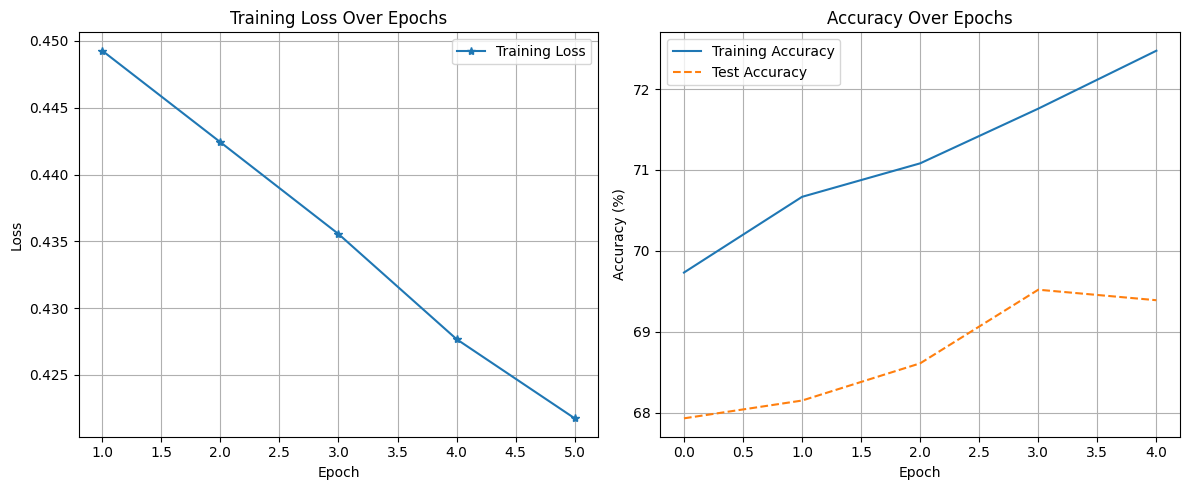

In [51]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_loss_history, label='Training Loss', marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Test Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Training Loop
train_losses = []
net = CSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
torch.optim.RMSprop or torch.optim.SGD(momentum=0.9)
num_epochs = 5
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        spk_rec = net(images)

        # Calculate loss
        loss = loss_fn(spk_rec, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
# store average loss per epoch
print(train_losses)

Epoch [1/5], Step [100/391], Loss: 0.7565
Epoch [1/5], Step [200/391], Loss: 0.6838
Epoch [1/5], Step [300/391], Loss: 0.6487
Epoch [2/5], Step [100/391], Loss: 0.6810
Epoch [2/5], Step [200/391], Loss: 0.6755
Epoch [2/5], Step [300/391], Loss: 0.6534
Epoch [3/5], Step [100/391], Loss: 0.5836
Epoch [3/5], Step [200/391], Loss: 0.5616
Epoch [3/5], Step [300/391], Loss: 0.6062
Epoch [4/5], Step [100/391], Loss: 0.5604
Epoch [4/5], Step [200/391], Loss: 0.5262
Epoch [4/5], Step [300/391], Loss: 0.5454
Epoch [5/5], Step [100/391], Loss: 0.5624
Epoch [5/5], Step [200/391], Loss: 0.5234
Epoch [5/5], Step [300/391], Loss: 0.5399
[0.7559431093123258, 0.6317636141996554, 0.5923226614437445, 0.5613770244828881, 0.5358983166992207]


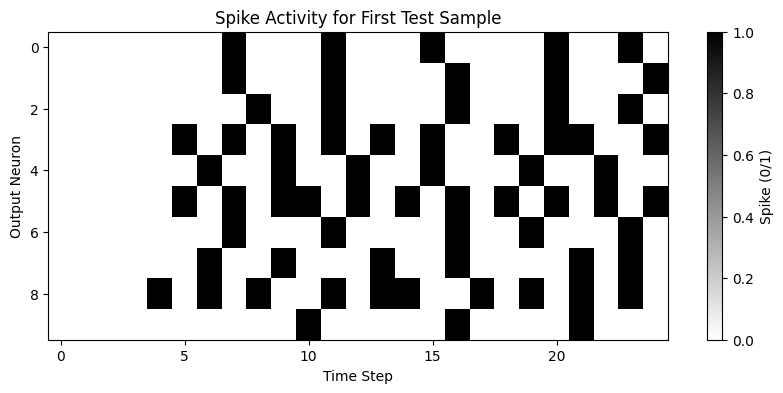

In [45]:
sample_images, _ = next(iter(test_loader))
sample_images = sample_images.to(device)

with torch.no_grad():
    spk_rec = net(sample_images)  # Shape: (time_steps, batch_size, num_classes)

# Plot spike trains for the first sample
plt.figure(figsize=(10, 4))
plt.imshow(spk_rec[:, 0, :].cpu().numpy().T, aspect='auto', cmap='binary')
plt.xlabel("Time Step")
plt.ylabel("Output Neuron")
plt.title("Spike Activity for First Test Sample")
plt.colorbar(label="Spike (0/1)")
plt.show()

## Plot the LOSS CURVE

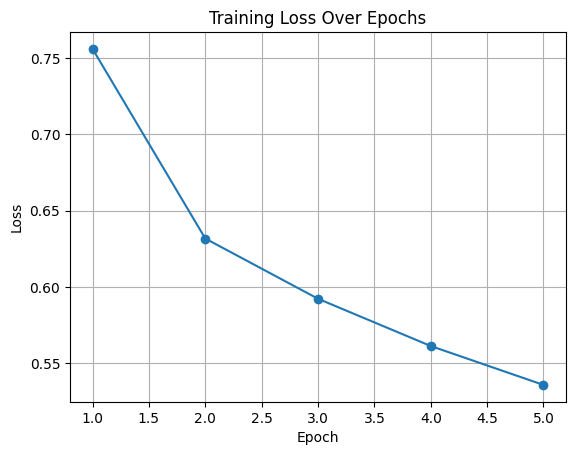

In [37]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

## Testing the Model

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        spk_rec = net(images)

        # Sum spikes over time
        _, predicted = torch.max(spk_rec.sum(0), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 60.91%


## Plot for Testing of Original Images

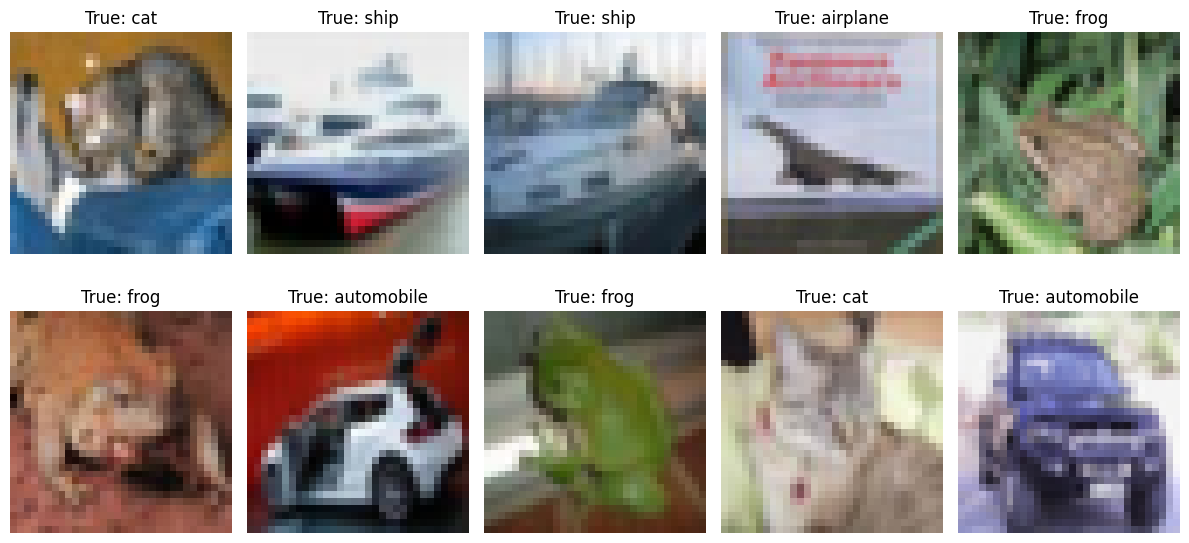

In [42]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of test data
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Convert images back to [0, 1] for display
images_denorm = images * 0.5 + 0.5  # Reverse Normalize (assuming mean=0.5, std=0.5)

# Plot 10 sample test images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(images_denorm[i].cpu().numpy(), (1, 2, 0)))
    plt.title(f"True: {class_names[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Plot for Testing Images: Original VS Predictions

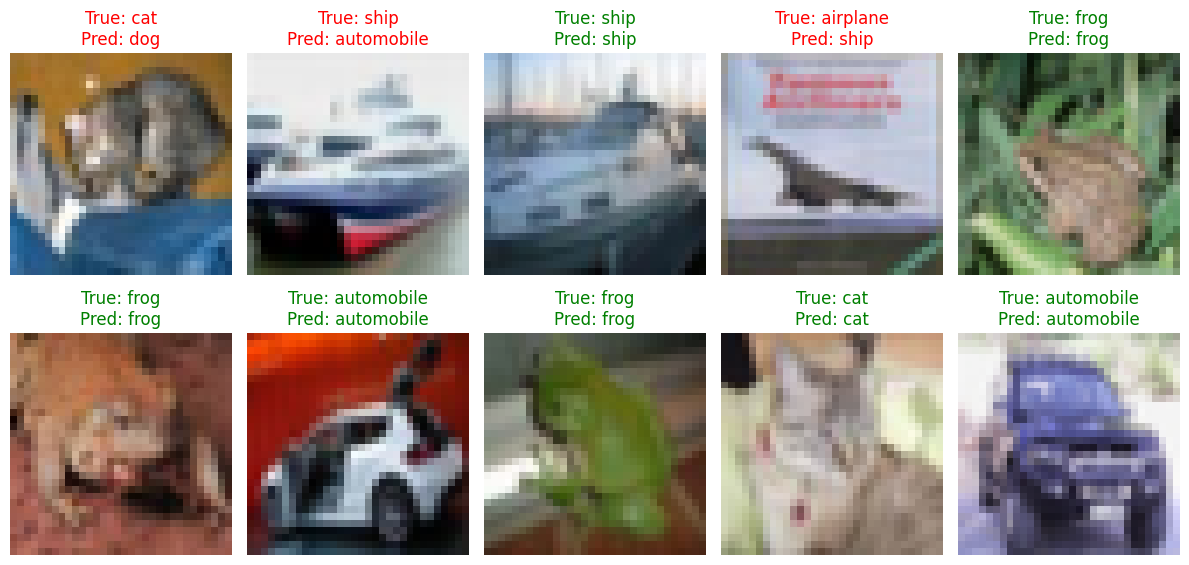

In [43]:
with torch.no_grad():
    spk_rec = net(images)  # Forward pass (returns spike counts)
    _, predicted = torch.max(spk_rec.sum(0), 1)  # Sum spikes over time

# Plot images with true vs predicted labels
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(images_denorm[i].cpu().numpy(), (1, 2, 0)))
    plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}", color='green' if labels[i] == predicted[i] else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Confusion Matrix

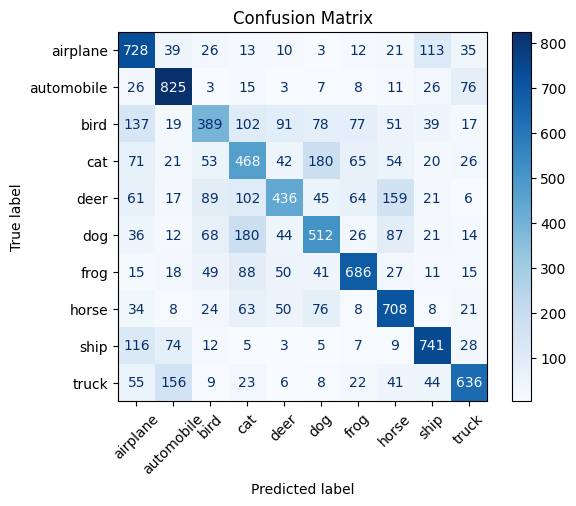

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# You may already have this from test loop
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        spk_rec = net(images)
        _, predicted = torch.max(spk_rec.sum(0), 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

## Plot the Convolutional Spiking Neural Networks

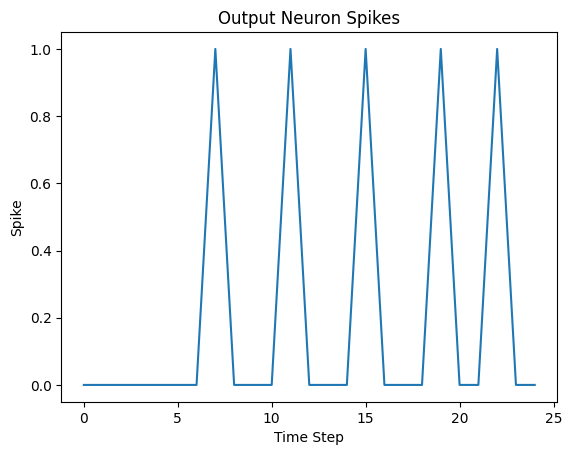

In [10]:
plt.figure()
plt.plot(spk_rec[:,0,0].detach().cpu().numpy())
plt.title("Output Neuron Spikes")
plt.xlabel("Time Step")
plt.ylabel("Spike")
plt.show()

In [ ]:
# Your code here :
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])